# Combinatorial library vs. ChEMBL

## Aims of this notebook

In this notebook we want to compare the combinatorial library to the ChEMBL 25 dataset:

1. How similar are recombined ligands to ChEMBL ligands?
2. Which recombined ligands have exact matches in ChEMBL?

Note that the combinatorial library is stored as `json` file (~6M molecules). The data needed for this notebook was extracted previously in notebook `4_1_combinatorial_library_data.ipynb` for easy and fast access here.

## Table of contents

1. Most similar ChEMBL ligands
2. Exact matches  
  2.1. Get exact matches  
  2.2. Get ChEMBL clients and set up filtering documentation  
  2.3. Get molecules from ChEMBL (by InChI key)  
  2.4. Get molecules with human targets in ChEMBL  
  2.5. Check molecule/target/assay/bioactivity distributions  
  2.6. Get active molecules (among the exact matches)  
  2.7. Get target metadata (PTC) for active molecules  
  2.8. Results  

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

from chembl_webresource_client.new_client import new_client
import ijson
import matplotlib.pyplot as plt
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw, PandasTools
from rdkit.Chem.Draw import IPythonConsole

from utils import get_protein_target_classifications

In [3]:
ACTIVITY_THRESHOLD = 500

## 1. Most similar ChEMBL ligands

## 2. Exact matches

### 2.1. Get exact matches

In [4]:
exact_matches = pd.read_json('../data/combinatorial_library/chembl_exact.json')

In [5]:
print(exact_matches.shape[0])
exact_matches.head()

299


,bond_ids,fragment_ids,hba,hbd,mwt,logp,n_atoms,chembl_exact,original_exact,original_substructure,inchi
0,"[[B1_7, GA_10], [AP_12, SE_13], [AP_11, GA_9]]","[GA_35, B1_19, AP_6, SE_1]",1,1,0,0,40,1,0,0,InChI=1S/C32H28ClFN4O2/c33-29-18-27(9-11-31(29...
1,"[[AP_9, FP_6], [AP_8, SE_8]]","[AP_99, SE_16, FP_25]",1,1,1,1,22,1,0,0,InChI=1S/C16H13N3O2S/c1-21-13-6-4-12(5-7-13)18...
2,"[[AP_9, FP_6], [AP_8, SE_6]]","[AP_99, FP_103, SE_138]",1,1,1,1,20,1,0,0,InChI=1S/C16H12N2OS/c19-15(17-13-9-5-2-6-10-13...
3,"[[AP_9, FP_6], [SE_7, AP_8]]","[SE_38, FP_103, AP_99]",1,1,1,1,21,1,0,0,InChI=1S/C16H11ClN2OS/c17-12-6-8-13(9-7-12)18-...
4,"[[B1_7, GA_10], [SE_14, AP_12], [AP_11, GA_9]]","[GA_35, B1_19, AP_6, SE_2]",1,1,0,0,41,1,0,0,InChI=1S/C32H26ClFN4O3/c33-28-18-26(9-11-30(28...


In [6]:
exact_matches.drop_duplicates('inchi', inplace=True)
exact_matches.shape[0]

298

### 2.2. Remove original ligands (exact and substructure matches)

In [7]:
original_ligand_matches = pd.concat(
    [
        pd.read_json('../data/combinatorial_library/original_exact.json'),
        pd.read_json('../data/combinatorial_library/original_substructure.json')
    ]
)
original_ligand_matches.shape

(360, 11)

In [8]:
exact_matches = exact_matches[
    exact_matches.apply(lambda x: x.inchi in original_ligand_matches.inchi.to_list(), axis=1)
]

In [9]:
print(f'Number of exact ChEMBL matches without original ligands: {exact_matches.shape[0]}')

Number of exact ChEMBL matches without original ligands: 80


### 2.2. Get ChEMBL clients and set up filtering documentation

In [10]:
similarity_client = new_client.similarity
molecule_client = new_client.molecule
activity_client = new_client.activity
target_client = new_client.target

In [11]:
def add_filtering_step(filtering, df, step_name):
    
    return filtering.append(
        pd.Series(
            [
                step_name,
                len(df.molecule_chembl_id.unique()),
                len(df.target_chembl_id.unique()),
                len(df.assay_chembl_id.unique()),
                df.shape[0]
            ],
            index=['filtering_step', 'molecules', 'targets', 'assays', 'activities']
        ),
        ignore_index=True
    )

In [12]:
# Initialize filtering table
filtering = pd.DataFrame(columns=['filtering_step', 'molecules', 'targets', 'assays', 'activities'])

### 2.3. Get molecules from ChEMBL (by InChI key)

- Get molecule data from ChEMBL
- Approved molecules?
- ATC classified molecules?

#### Get molecule data from ChEMBL

In [13]:
# Get InChI keys (will be queries for ChEMBL)
exact_matches['inchi_key'] = exact_matches.inchi.apply(lambda x: Chem.InchiToInchiKey(x))

In [14]:
def get_molecules(inchi_keys):
    
    result = [molecule_client.get(inchi_key) for inchi_key in inchi_keys]
    
    molecules = pd.DataFrame(result)
    molecules = molecules[['molecule_chembl_id', 'molecule_structures', 'first_approval', 'atc_classifications', 'indication_class', 'pref_name']]
    molecules['smiles'] = molecules.molecule_structures.apply(lambda x: x['canonical_smiles'])
    molecules['inchi'] = molecules.molecule_structures.apply(lambda x: x['standard_inchi'])
    molecules.drop('molecule_structures', axis=1, inplace=True)
    PandasTools.AddMoleculeColumnToFrame(molecules, 'smiles')
    
    print(f'Number of queries: {len(inchi_keys)}')
    print(f'Number of query results: {molecules.shape[0]}')
    
    return molecules

In [15]:
molecules = get_molecules(exact_matches.inchi_key)

Number of queries: 80
Number of query results: 80


#### Approved molecules?

,molecule_chembl_id,first_approval,atc_classifications,indication_class,pref_name,smiles,inchi,ROMol
20,CHEMBL490,1992.0,[N06AB05],Antidepressant,PAROXETINE,Fc1ccc([C@@H]2CCNC[C@H]2COc2ccc3c(c2)OCO3)cc1,InChI=1S/C19H20FNO3/c20-15-3-1-13(2-4-15)17-7-...,

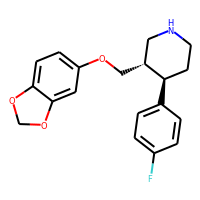

In [16]:
# Check if first_approval field is not empty
molecules[~molecules.first_approval.isna()]

**`CHEMBL64`, Isoniazid**

- [ChEMBL compound report card](https://www.ebi.ac.uk/chembl/compound_report_card/CHEMBL64/)
- [Drugbank](https://www.drugbank.ca/drugs/DB00951)
  > **Description**: Antibacterial agent used primarily as a tuberculostatic. It remains the treatment of choice for tuberculosis. </br>
  > **Mechanism of action**: Isoniazid is a prodrug and must be activated by bacterial catalase. Specficially, activation is associated with reduction of the mycobacterial ferric **KatG catalase-peroxidase** by hydrazine and reaction with oxygen to form an oxyferrous enzyme complex. Once activated, isoniazid inhibits the synthesis of mycoloic acids, an essential component of the bacterial cell wall. At therapeutic levels isoniazid is bacteriocidal against actively growing intracellular and extracellular *Mycobacterium tuberculosis* organisms. Specifically isoniazid inhibits **InhA, the enoyl reductase** from *Mycobacterium tuberculosis*, by forming a covalent adduct with the NAD cofactor. It is the INH-NAD adduct that acts as a slow, tight-binding competitive inhibitor of InhA. </br>
  > **Target**: Catalase-peroxidase (UniProt ID [P9WIE5](https://www.uniprot.org/uniprot/P9WIE5))
  
- Off-targets? Kinases?
  - Cytochrome P450 2E1 and Arylamine N-acetyltranserases are associated with isoniazid side effects ([DrugBank's "Pharmacogenomic Effects/ADRs"](https://www.drugbank.ca/drugs/DB00951)).
  - [SwissTargetPredictions](http://swisstargetprediction.ch/result.php?job=1698711713&organism=Homo_sapiens) (ligand-based target prediction) predicts a few kinases in the top 15 off-targets.
  - [ProBis](http://probis.cmm.ki.si/browse.php?job_id=2cca.A) (structure-based target prediction for [2CCA](https://www.rcsb.org/structure/2cca)) predicts mainly peroxidases (no kinases).

**`CHEMBL490`, Paroxetine**

- [ChEMBL compound report card](https://www.ebi.ac.uk/chembl/compound_report_card/CHEMBL490/)
- [DrugBank](https://www.drugbank.ca/drugs/DB00715)
  > **Description**: Paroxetine is a selective serotonin reuptake inhibitor (SSRI) drug commonly known as Paxil. It has a variety of uses, including the treatment of anxiety disorders, major depression, posttraumatic stress disorder, and symptoms of menopause, among others. </br>
  > **Mode of action**: Paroxetine enhances serotonergic activity via the inhibition presynaptic reuptake of serotonin by the **serotonin (SERT) receptor**. This inhibition raises the level of serotonin in the synaptic cleft, relieving various symptoms. </br>
  > **Target**: Sodium-dependent serotonin transporter (UniProt ID [P31645](https://www.uniprot.org/uniprot/P31645))
- Off-targets? Kinases? 
  - Cytochrome P450 enzymes ([Sanchez et al. 2014](https://insights.ovid.com/article/00004850-201407000-00001)) and G protein-coupled receptor kinase 2 (GRK2 (AGC kinase group)) ([Thal et al. 2012](https://pubs.acs.org/doi/10.1021/cb3003013))
  - [SwissTargetPredictions](http://www.swisstargetprediction.ch/result.php?job=1696651044&organism=Homo_sapiens) (ligand-based target prediction) predicts many membrane receptors and channels - and from rank 15 on a variety of kinases.
  - [ProBis](http://probis.cmm.ki.si/?what=job&job_id=25062009328288) (structure-based target prediction for [5I6X](https://www.rcsb.org/structure/5I6X)) predicts only few kinase/ATP-binding proteins on lower ranks.

#### ATC classified molecules?

In [17]:
# Check if atc classified field is not empty
molecules[molecules.atc_classifications.str.len() != 0].drop('ROMol', axis=1)

,molecule_chembl_id,first_approval,atc_classifications,indication_class,pref_name,smiles,inchi
20,CHEMBL490,1992.0,[N06AB05],Antidepressant,PAROXETINE,Fc1ccc([C@@H]2CCNC[C@H]2COc2ccc3c(c2)OCO3)cc1,InChI=1S/C19H20FNO3/c20-15-3-1-13(2-4-15)17-7-...


Same as retrieved via the approved molecules query.

### 2.4. Get molecules with human targets in ChEMBL

- Get activities (by molecule ChEMBL IDs)
- Remove activities for non-human target origanisms

#### Get activities (by molecule ChEMBL IDs)

In [18]:
def get_activities(molecule_ids):
    
    activities = activity_client.filter(
        molecule_chembl_id__in=molecule_ids,
        type='IC50', 
        relation='=', 
        assay_type='B'
    ).only(
        'activity_id','assay_chembl_id', 'assay_description', 'assay_type', \
        'molecule_chembl_id', 'type', 'standard_units', 'relation', 'standard_value', \
        'target_chembl_id', 'target_organism', 'target_pref_name'
    )
    
    activities_df = pd.DataFrame.from_records(list(activities))
    activities_df = activities_df.astype({'standard_value': 'float'})
    
    print(f'Number of queries: {len(molecule_ids)}')
    print(f'Number of query results: {activities_df.shape[0]}')
    
    return activities_df

In [19]:
activities = get_activities(list(molecules.molecule_chembl_id))

Number of queries: 80
Number of query results: 165


In [65]:
activities[activities.molecule_chembl_id == 'CHEMBL490']

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_pref_name,type,units,value
26,2483368,CHEMBL986142,Inhibition of norepinephrine uptake at human NET expressed in MDCK cells,B,CHEMBL490,=,nM,100.00,CHEMBL222,Norepinephrine transporter,IC50,nM,100.0
27,2483386,CHEMBL986143,Inhibition of serotonin uptake at human SERT expressed in JAR cells,B,CHEMBL490,=,nM,2.00,CHEMBL228,Serotonin transporter,IC50,nM,2.0
60,7719130,CHEMBL1909094,DRUGMATRIX: Norepinephrine Transporter radioligand binding (ligand: [125I] RTI-55),B,CHEMBL490,=,nM,86.00,CHEMBL222,Norepinephrine transporter,IC50,uM,0.086
64,7719180,CHEMBL1909136,"DRUGMATRIX: CYP450, 2D6 enzyme inhibition (substrate: 3-Cyano-7-ethoxycoumarin)",B,CHEMBL490,=,nM,1000.00,CHEMBL289,Cytochrome P450 2D6,IC50,uM,1.0
65,7719194,CHEMBL1909143,DRUGMATRIX: Dopamine Transporter radioligand binding (ligand: [125I] RTI-55),B,CHEMBL490,=,nM,672.00,CHEMBL238,Dopamine transporter,IC50,uM,0.672
66,7721246,CHEMBL1909170,DRUGMATRIX: Muscarinic M1 radioligand binding (ligand: [3H] N-Methylscopolamine),B,CHEMBL490,=,nM,145.00,CHEMBL216,Muscarinic acetylcholine receptor M1,IC50,uM,0.145
67,7721248,CHEMBL1909171,DRUGMATRIX: Muscarinic M2 radioligand binding (ligand: [3H] N-Methylscopolamine),B,CHEMBL490,=,nM,532.00,CHEMBL211,Muscarinic acetylcholine receptor M2,IC50,uM,0.532
68,7721250,CHEMBL1909172,DRUGMATRIX: Muscarinic M3 radioligand binding (ligand: [3H] N-Methylscopolamine),B,CHEMBL490,=,nM,179.00,CHEMBL245,Muscarinic acetylcholine receptor M3,IC50,uM,0.179
69,7721252,CHEMBL1909173,DRUGMATRIX: Muscarinic M4 radioligand binding (ligand: [3H] N-Methylscopolamine),B,CHEMBL490,=,nM,244.00,CHEMBL1821,Muscarinic acetylcholine receptor M4,IC50,uM,0.244
70,7721254,CHEMBL1909174,DRUGMATRIX: Muscarinic M5 radioligand binding (ligand: [3H] N-Methylscopolamine),B,CHEMBL490,=,nM,123.00,CHEMBL2035,Muscarinic acetylcholine receptor M5,IC50,uM,0.123


In [21]:
activities.columns

Index(['activity_id', 'assay_chembl_id', 'assay_description', 'assay_type',
       'molecule_chembl_id', 'relation', 'standard_units', 'standard_value',
       'target_chembl_id', 'target_organism', 'target_pref_name', 'type',
       'units', 'value'],
      dtype='object')

In [22]:
filtering = add_filtering_step(filtering, activities, 'ChEMBL bioactivity entries')
filtering

,filtering_step,molecules,targets,assays,activities
0,ChEMBL bioactivity entries,39,100,155,165


**Important**: Check if all standard units are really nM.

In [23]:
activities.groupby(
    ['standard_units']
).size()

standard_units
nM    165
dtype: int64

In [24]:
# Just to be sure, drop all entries with standard unit other than nM 
# Note: One could also perform a unit conversion here
activities.drop(
    index=activities[activities.standard_units != 'nM'].index,
    inplace=True
)

In [25]:
filtering = add_filtering_step(filtering, activities, 'Remove non-nM activities')
filtering

,filtering_step,molecules,targets,assays,activities
0,ChEMBL bioactivity entries,39,100,155,165
1,Remove non-nM activities,39,100,155,165


#### Remove activities for non-human target organisms

In [26]:
activities.groupby('target_organism').size()

target_organism
Bos taurus                 1
Homo sapiens             149
Mus musculus               2
Rattus norvegicus          3
Staphylococcus aureus      1
dtype: int64

In [27]:
activities = activities[activities.target_organism == 'Homo sapiens'].copy()
activities.drop('target_organism', axis=1, inplace=True)

In [28]:
filtering = add_filtering_step(filtering, activities, 'Only human entries')
filtering

,filtering_step,molecules,targets,assays,activities
0,ChEMBL bioactivity entries,39,100,155,165
1,Remove non-nM activities,39,100,155,165
2,Only human entries,38,92,139,149


### 2.5. Check molecule/target/assay/bioactivity distributions

#### How many targets are reported per molecule?

Text(0.5, 0, 'Number of targets per molecule')

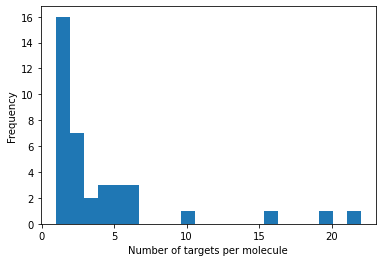

In [29]:
n_targets_per_molecule = activities.groupby(
    ['molecule_chembl_id']
)['target_chembl_id'].size()

ax = n_targets_per_molecule.plot(kind='hist', bins=n_targets_per_molecule.max())
ax.set_xlabel('Number of targets per molecule')

#### How many different assays were used to measure molecule-target activities?

Text(0.5, 0, 'Number of assays per molecule-target pair')

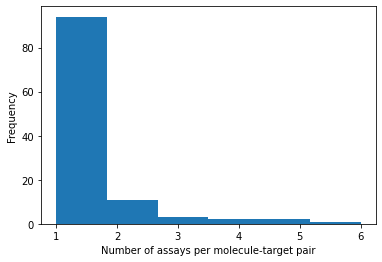

In [30]:
n_assays_per_molecule_target = activities.groupby(
    ['molecule_chembl_id', 'target_chembl_id']
)['assay_chembl_id'].size()

ax = n_assays_per_molecule_target.plot(kind='hist', bins=n_assays_per_molecule_target.max())
ax.set_xlabel('Number of assays per molecule-target pair')

#### Look at all activities measured per molecule-target-assay combination

Get all activities for each molecule-target-assay combination.

In [31]:
activities_per_molecule_target_assay = activities.groupby(
    ['molecule_chembl_id', 'target_chembl_id', 'target_pref_name', 'assay_chembl_id', 'assay_description']
)['standard_value'].apply(list).reset_index()

Show examples.

In [32]:
activities_per_molecule_target_assay.head()

,molecule_chembl_id,target_chembl_id,target_pref_name,assay_chembl_id,assay_description,standard_value
0,CHEMBL1080394,CHEMBL2971,Tyrosine-protein kinase JAK2,CHEMBL1107753,Inhibition of GST-tagged JAK2 kinase,[467.0]
1,CHEMBL1082821,CHEMBL2896,cGMP-dependent protein kinase 2,CHEMBL1120084,Inhibition of PRKG2,[24.0]
2,CHEMBL1082821,CHEMBL2973,Rho-associated protein kinase 2,CHEMBL1120081,Inhibition of ROCK2 by luciferase based ATP de...,[4.0]
3,CHEMBL1082821,CHEMBL3032,Protein kinase N2,CHEMBL1120085,Inhibition of PRKCL2,[14.0]
4,CHEMBL1082821,CHEMBL3582,Protein kinase C epsilon,CHEMBL1120086,Inhibition of PRKCE,[1000.0]


Get all activities for each molecule-target combination.

In [33]:
activities_per_molecule_target = activities_per_molecule_target_assay.groupby(
    ['molecule_chembl_id', 'target_chembl_id']
)['standard_value'].apply(list).reset_index()

Get molecule-target pairs that have multiple activities from either multiple assays or a single assay.

In [34]:
activities_per_molecule_target[
    (activities_per_molecule_target.standard_value.apply(len) > 1) | (activities_per_molecule_target.standard_value.apply(len)[0] > 1)
].reset_index()

,index,molecule_chembl_id,target_chembl_id,standard_value
0,11,CHEMBL1287920,CHEMBL4630,"[[4.0], [7.0]]"
1,21,CHEMBL1652697,CHEMBL3629,"[[13.0, 6.0, 10.0], [7400.0]]"
2,31,CHEMBL2170597,CHEMBL4722,"[[10.0], [8.9], [10.0], [10.0], [10.0]]"
3,32,CHEMBL2203552,CHEMBL2543,"[[348.0], [8.0]]"
4,47,CHEMBL2208034,CHEMBL2971,"[[695.0], [386.4], [2.2]]"
5,50,CHEMBL225519,CHEMBL2208,"[[470.0], [171.0]]"
6,55,CHEMBL225519,CHEMBL308,"[[250.0], [170.0]]"
7,57,CHEMBL225519,CHEMBL3116,"[[34.0], [34.0]]"
8,63,CHEMBL225519,CHEMBL4718,"[[2670.0], [2670.0]]"
9,64,CHEMBL225519,CHEMBL5443,"[[10.0], [10.0], [10.0], [10.0]]"


### 2.6. Get active molecules (among the exact matches)

- Get highest activity (lowest IC50) per molecule-target pair
- Get molecules that are "active" (<=`ACTIVITY_THRESHOLD` nM) against at least one target

#### Get highest activity (lowest IC50) per molecule-target pair

Get lowest IC50 value per molecule-target pair by (i) sorting the DataFrame by molecule ChEMBL ID, target ChEMBL ID and activity value (ascending), (ii) group activites by molecule-target pairs, and (iii) take the first activity value (i.e. the minimum value because of step (ii)) per molecule-target pair (i.e. per group).

In [35]:
activities_min = activities.sort_values(
    ['molecule_chembl_id', 'target_chembl_id', 'standard_value']
).groupby(
    ['molecule_chembl_id', 'target_chembl_id']
).first().reset_index()

In [36]:
filtering = add_filtering_step(filtering, activities_min, 'Get minimum IC50 per molecule-target pair')
filtering

,filtering_step,molecules,targets,assays,activities
0,ChEMBL bioactivity entries,39,100,155,165
1,Remove non-nM activities,39,100,155,165
2,Only human entries,38,92,139,149
3,Get minimum IC50 per molecule-target pair,38,92,110,113


#### Get molecules that are "active" (<=`ACTIVITY_THRESHOLD` nM) against at least one target

In [37]:
activities_active = activities_min[activities_min.standard_value <= ACTIVITY_THRESHOLD]
activities_active.head()

,molecule_chembl_id,target_chembl_id,activity_id,assay_chembl_id,assay_description,assay_type,relation,standard_units,standard_value,target_pref_name,type,units,value
0,CHEMBL1080394,CHEMBL2971,3227667,CHEMBL1107753,Inhibition of GST-tagged JAK2 kinase,B,=,nM,467.0,Tyrosine-protein kinase JAK2,IC50,nM,467.0
1,CHEMBL1082821,CHEMBL2896,3308846,CHEMBL1120084,Inhibition of PRKG2,B,=,nM,24.0,cGMP-dependent protein kinase 2,IC50,nM,24.0
2,CHEMBL1082821,CHEMBL2973,3308843,CHEMBL1120081,Inhibition of ROCK2 by luciferase based ATP de...,B,=,nM,4.0,Rho-associated protein kinase 2,IC50,nM,4.0
3,CHEMBL1082821,CHEMBL3032,3308847,CHEMBL1120085,Inhibition of PRKCL2,B,=,nM,14.0,Protein kinase N2,IC50,nM,14.0
5,CHEMBL1082821,CHEMBL6088,3308849,CHEMBL1120087,Inhibition of CDC42,B,=,nM,54.0,Cell division control protein 42 homolog,IC50,nM,54.0


In [38]:
filtering = add_filtering_step(filtering, activities_active, 'Only "active" molecule-target pairs')
filtering

,filtering_step,molecules,targets,assays,activities
0,ChEMBL bioactivity entries,39,100,155,165
1,Remove non-nM activities,39,100,155,165
2,Only human entries,38,92,139,149
3,Get minimum IC50 per molecule-target pair,38,92,110,113
4,"Only ""active"" molecule-target pairs",25,57,65,66


Text(0.5, 0, 'IC50 values for active molecule-target pairs')

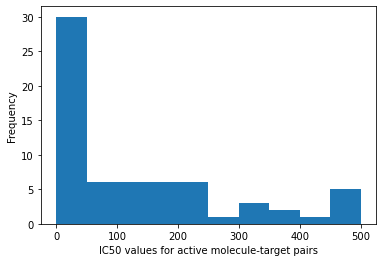

In [39]:
ax = activities_active.standard_value.plot(kind='hist')
ax.set_xlabel('IC50 values for active molecule-target pairs')

### 2.7. Get target metadata (PTC) for active molecules

- Get ChEMBL target details: Protein target classification (PTC)
- Show enzyme group distribution for unique target ChEMBL IDs
- Combine molecule, bioactivity, and target information

#### Get ChEMBL target details: Protein target classification (PTC)

In order to access the protein target classification, we follow the instructions given here: https://github.com/chembl/chembl_webservices_2/issues/95

In [40]:
target_chembl_ids = list(activities_active.target_chembl_id.unique())
print(f'Number of unique targets (target ChEMBL IDs): {len(target_chembl_ids)}')

Number of unique targets (target ChEMBL IDs): 57


Get PTC for target ChEMBL IDs.

In [41]:
protein_target_classifications = get_protein_target_classifications(target_chembl_ids)
print(f'Number of PTCs (multiple PTCs per target possible): {protein_target_classifications.shape[0]}')

Number of PTCs (multiple PTCs per target possible): 66


In [42]:
protein_target_classifications.head()

,target_chembl_id,l1,l2,l3,l4,l5,l6,l7,l8,protein_class_id,component_id,protein_classification_id
0,CHEMBL2971,Enzyme,Kinase,Protein Kinase,TK protein kinase group,Tyrosine protein kinase JakA family,None,None,None,152,1302,152
1,CHEMBL2971,Enzyme,Kinase,Protein Kinase,TK protein kinase group,Tyrosine protein kinase JakB family,None,None,None,153,1302,153
2,CHEMBL2896,Enzyme,Kinase,Protein Kinase,AGC protein kinase group,AGC protein kinase PKG family,None,None,None,207,1226,207
3,CHEMBL2973,Enzyme,Kinase,Protein Kinase,AGC protein kinase group,AGC protein kinase DMPK family,AGC protein kinase ROCK subfamily,None,None,315,1304,315
4,CHEMBL3032,Enzyme,Kinase,Protein Kinase,AGC protein kinase group,AGC protein kinase PKN family,None,None,None,208,4957,208


Show targets with multiple PTCs.

In [43]:
n_ptc_per_target = protein_target_classifications.groupby('target_chembl_id').size()
protein_target_classifications[protein_target_classifications.target_chembl_id.isin(n_ptc_per_target[n_ptc_per_target > 1].index)]

,target_chembl_id,l1,l2,l3,l4,l5,l6,l7,l8,protein_class_id,component_id,protein_classification_id
0,CHEMBL2971,Enzyme,Kinase,Protein Kinase,TK protein kinase group,Tyrosine protein kinase JakA family,None,None,None,152,1302,152
1,CHEMBL2971,Enzyme,Kinase,Protein Kinase,TK protein kinase group,Tyrosine protein kinase JakB family,None,None,None,153,1302,153
8,CHEMBL2095191,Enzyme,Kinase,Protein kinase regulatory subunit,None,None,None,None,None,129,699,129
9,CHEMBL2095191,Enzyme,Kinase,Protein Kinase,Other protein kinase group,Other protein kinase CK2 family,None,None,None,252,1946,252
10,CHEMBL2095191,Enzyme,Kinase,Protein Kinase,Other protein kinase group,Other protein kinase CK2 family,None,None,None,252,2389,252
15,CHEMBL3883328,Enzyme,Kinase,Protein kinase regulatory subunit,None,None,None,None,None,129,699,129
16,CHEMBL3883328,Enzyme,Kinase,Protein Kinase,Other protein kinase group,Other protein kinase CK2 family,None,None,None,252,2389,252
29,CHEMBL2148,Enzyme,Kinase,Protein Kinase,TK protein kinase group,Tyrosine protein kinase JakA family,None,None,None,152,490,152
30,CHEMBL2148,Enzyme,Kinase,Protein Kinase,TK protein kinase group,Tyrosine protein kinase JakB family,None,None,None,153,490,153
32,CHEMBL2835,Enzyme,Kinase,Protein Kinase,TK protein kinase group,Tyrosine protein kinase JakA family,None,None,None,152,1164,152


Select per target the PTC that has the least `None` values (if the same number of `None`, select first entry).

In [44]:
group_representatives = []

for name, group in protein_target_classifications.groupby('target_chembl_id', sort=False):
    
    if len(group) == 1:
        group_representatives.append(group)
    else:
        ix_least_none = group['l1 l2 l3 l4 l5 l6 l7 l8'.split()].isna().sum(axis=1).idxmin()
        group_representatives.append(group.loc[[ix_least_none]])
        
protein_target_classifications = pd.concat(group_representatives)
print(f'Number of PTCs (after deduplicating PTCs per target): {protein_target_classifications.shape[0]}')

Number of PTCs (after deduplicating PTCs per target): 57


#### Show enzyme group distribution for unique target ChEMBL IDs

In [45]:
protein_target_classifications.groupby(by='l2').size()

l2
Electrochemical transporter             2
Family A G protein-coupled receptor     4
Kinase                                 49
Oxidoreductase                          1
dtype: int64

#### Combine molecule, bioactivity, and target information

Merge bioactivities and PTC information on target ChEMBL IDs.

In [46]:
activities_active = pd.merge(
    activities_active, protein_target_classifications, on='target_chembl_id', how='left'
).sort_values(
    by=['molecule_chembl_id', 'standard_value']
)[['molecule_chembl_id', 'target_chembl_id', 'target_pref_name', 'l1', 'l2', 'l3', 'l4', 'l5', 'l6', 'assay_chembl_id', 'assay_description', 'standard_value']]

activities_active.fillna('Unknown', inplace=True)

print(activities_active.shape)
activities_active.head()

(66, 12)


,molecule_chembl_id,target_chembl_id,target_pref_name,l1,l2,l3,l4,l5,l6,assay_chembl_id,assay_description,standard_value
0,CHEMBL1080394,CHEMBL2971,Tyrosine-protein kinase JAK2,Enzyme,Kinase,Protein Kinase,TK protein kinase group,Tyrosine protein kinase JakA family,Unknown,CHEMBL1107753,Inhibition of GST-tagged JAK2 kinase,467.0
2,CHEMBL1082821,CHEMBL2973,Rho-associated protein kinase 2,Enzyme,Kinase,Protein Kinase,AGC protein kinase group,AGC protein kinase DMPK family,AGC protein kinase ROCK subfamily,CHEMBL1120081,Inhibition of ROCK2 by luciferase based ATP de...,4.0
3,CHEMBL1082821,CHEMBL3032,Protein kinase N2,Enzyme,Kinase,Protein Kinase,AGC protein kinase group,AGC protein kinase PKN family,Unknown,CHEMBL1120085,Inhibition of PRKCL2,14.0
1,CHEMBL1082821,CHEMBL2896,cGMP-dependent protein kinase 2,Enzyme,Kinase,Protein Kinase,AGC protein kinase group,AGC protein kinase PKG family,Unknown,CHEMBL1120084,Inhibition of PRKG2,24.0
4,CHEMBL1082821,CHEMBL6088,Cell division control protein 42 homolog,Unclassified protein,Unknown,Unknown,Unknown,Unknown,Unknown,CHEMBL1120087,Inhibition of CDC42,54.0


### 2.8. Results

- Number of targets per molecule
- Targets per molecule
- Molecules without kinase target(s)
- Molecules with kinase target(s)
- Molecules with kinase target(s) with activity of <= 5 nM

`activities_active` contains information for each ChEMBL molecule-target combination.

#### Number of targets per molecule

Text(0.5, 0, 'Number of targets per molecule')

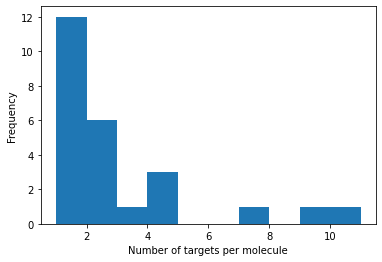

In [47]:
ax = activities_active.groupby(['molecule_chembl_id'])['target_chembl_id'].size().plot(kind='hist')
ax.set_xlabel('Number of targets per molecule')

#### Targets per molecule

In [48]:
pd.set_option("display.max_rows", 100)
pd.set_option('max_colwidth', 200)

In [49]:
molecules_with_targets = pd.DataFrame(
    [
        activities_active.groupby(['molecule_chembl_id'])['l2'].apply(list),
        activities_active.groupby(['molecule_chembl_id'])['target_pref_name'].apply(list),
        activities_active.groupby(['molecule_chembl_id'])['standard_value'].apply(list),
    ]
).transpose()

print(f'Number of molecules with human targets that have activity <= {ACTIVITY_THRESHOLD}: {molecules_with_targets.shape[0]}')

Number of molecules with human targets that have activity <= 500: 25


In [50]:
# Add molecule name
molecules_with_targets = pd.merge(
    molecules_with_targets, molecules[['molecule_chembl_id', 'pref_name']], on='molecule_chembl_id', how='left'
)

In [51]:
molecules_with_targets

,molecule_chembl_id,l2,target_pref_name,standard_value,pref_name
0,CHEMBL1080394,[Kinase],[Tyrosine-protein kinase JAK2],[467.0],None
1,CHEMBL1082821,"[Kinase, Kinase, Kinase, Unknown]","[Rho-associated protein kinase 2, Protein kinase N2, cGMP-dependent protein kinase 2, Cell division control protein 42 homolog]","[4.0, 14.0, 24.0, 54.0]",None
2,CHEMBL1231626,[Kinase],[Serine/threonine-protein kinase Chk1],[3.0],None
3,CHEMBL1287920,[Kinase],[Serine/threonine-protein kinase Chk1],[4.0],None
4,CHEMBL1354522,[Kinase],[Tyrosine-protein kinase Lyn],[500.0],None
5,CHEMBL1615027,[Kinase],[Tyrosine-protein kinase JAK2],[1.8],None
6,CHEMBL1652697,"[Kinase, Kinase]","[Casein kinase II, Casein kinase II alpha]","[6.0, 6.0]",None
7,CHEMBL1738733,"[Kinase, Kinase]","[Dual-specificity tyrosine-phosphorylation regulated kinase 1A, Dual specificity tyrosine-phosphorylation-regulated kinase 1B]","[7.6, 37.0]",None
8,CHEMBL2035603,"[Kinase, Kinase, Kinase]","[Serine/threonine-protein kinase PIM1, Serine/threonine-protein kinase PIM3, Casein kinase II alpha'/ beta]","[17.0, 18.0, 231.0]",None
9,CHEMBL2036007,[Kinase],[Tyrosine-protein kinase SRC],[25.1],None


#### Molecules without kinase target(s)

In [52]:
molecules_with_targets[~molecules_with_targets.l2.apply(lambda x: 'Kinase' in x)]

,molecule_chembl_id,l2,target_pref_name,standard_value,pref_name
21,CHEMBL490,"[Electrochemical transporter, Oxidoreductase, Electrochemical transporter, Family A G protein-coupled receptor, Family A G protein-coupled receptor, Family A G protein-coupled receptor, Family A G...","[Serotonin transporter, Myeloperoxidase, Norepinephrine transporter, Muscarinic acetylcholine receptor M5, Muscarinic acetylcholine receptor M1, Muscarinic acetylcholine receptor M3, Muscarinic ac...","[0.08, 20.0, 86.0, 123.0, 145.0, 179.0, 244.0]",PAROXETINE


#### Molecules with kinase target(s)

Keep only molecule-target pairs where target=kinase.

In [53]:
activities_active_kinases = activities_active[
    activities_active.l2 == 'Kinase'
]

In [54]:
filtering = add_filtering_step(filtering, activities_active_kinases, 'Only molecule-kinase pairs')
filtering

,filtering_step,molecules,targets,assays,activities
0,ChEMBL bioactivity entries,39,100,155,165
1,Remove non-nM activities,39,100,155,165
2,Only human entries,38,92,139,149
3,Get minimum IC50 per molecule-target pair,38,92,110,113
4,"Only ""active"" molecule-target pairs",25,57,65,66
5,Only molecule-kinase pairs,24,49,57,58


Across all molecule-target pairs count kinase groups.

In [55]:
activities_active_kinases.l4.apply(lambda x: x.split()[0]).value_counts()

TK       15
CMGC     11
Other    10
TKL       7
CAMK      7
AGC       5
CK1       3
Name: l4, dtype: int64

Summarize target information per molecule (`molecules_with_kinase_targets`).

In [56]:
molecules_with_kinase_targets = pd.DataFrame(
    [
        activities_active_kinases.groupby(['molecule_chembl_id'])['l4'].apply(list),
        activities_active_kinases.groupby(['molecule_chembl_id'])['target_pref_name'].apply(list),
        activities_active_kinases.groupby(['molecule_chembl_id'])['standard_value'].apply(list),
    ]
).transpose()
print(f'Number of molecules with kinase target(s): {molecules_with_kinase_targets.shape[0]}')

Number of molecules with kinase target(s): 24


Show molecules with kinase targets (sorted by the molecules' minimum activity value):

In [57]:
molecules_with_kinase_targets = molecules_with_kinase_targets.loc[molecules_with_kinase_targets.standard_value.apply(min).sort_values().index]
molecules_with_kinase_targets

,l4,target_pref_name,standard_value
molecule_chembl_id,,,
CHEMBL526479,"[TKL protein kinase group, CMGC protein kinase group]","[Serine/threonine-protein kinase B-raf, Mitogen-activated protein kinase; ERK1/ERK2]","[0.03, 9.0]"
CHEMBL2203552,"[CMGC protein kinase group, CK1 protein kinase group, CK1 protein kinase group, CK1 protein kinase group]","[Glycogen synthase kinase-3 beta, Casein kinase I gamma 2, Casein kinase I alpha, Casein kinase I delta]","[1.491, 8.0, 9.0, 68.0]"
CHEMBL1615027,[TK protein kinase group],[Tyrosine-protein kinase JAK2],[1.8]
CHEMBL2208034,"[TK protein kinase group, TK protein kinase group, TK protein kinase group, TK protein kinase group, TK protein kinase group, TK protein kinase group, AGC protein kinase group, TK protein kinase g...","[Tyrosine-protein kinase JAK2, Platelet-derived growth factor receptor beta, Tyrosine-protein kinase JAK1, Tyrosine-protein kinase receptor FLT3, Tyrosine-protein kinase JAK3, Stem cell growth fac...","[2.2, 125.4, 134.3, 139.7, 214.2, 225.8, 313.8, 348.3, 370.0, 375.4, 483.6]"
CHEMBL1231626,[CAMK protein kinase group],[Serine/threonine-protein kinase Chk1],[3.0]
CHEMBL3938208,"[CMGC protein kinase group, CMGC protein kinase group]","[CDK8/Cyclin C, Cell division protein kinase 8]","[3.8, 70.0]"
CHEMBL1082821,"[AGC protein kinase group, AGC protein kinase group, AGC protein kinase group]","[Rho-associated protein kinase 2, Protein kinase N2, cGMP-dependent protein kinase 2]","[4.0, 14.0, 24.0]"
CHEMBL1287920,[CAMK protein kinase group],[Serine/threonine-protein kinase Chk1],[4.0]
CHEMBL1652697,"[Other protein kinase group, Other protein kinase group]","[Casein kinase II, Casein kinase II alpha]","[6.0, 6.0]"


In [58]:
# Add SMILES to molecule-kinase dataset
molecules_with_kinase_targets = pd.merge(
    molecules_with_kinase_targets, molecules[['molecule_chembl_id', 'smiles']], on='molecule_chembl_id', how='left'
)

Molecule ChEMBL ID | minimum activity value


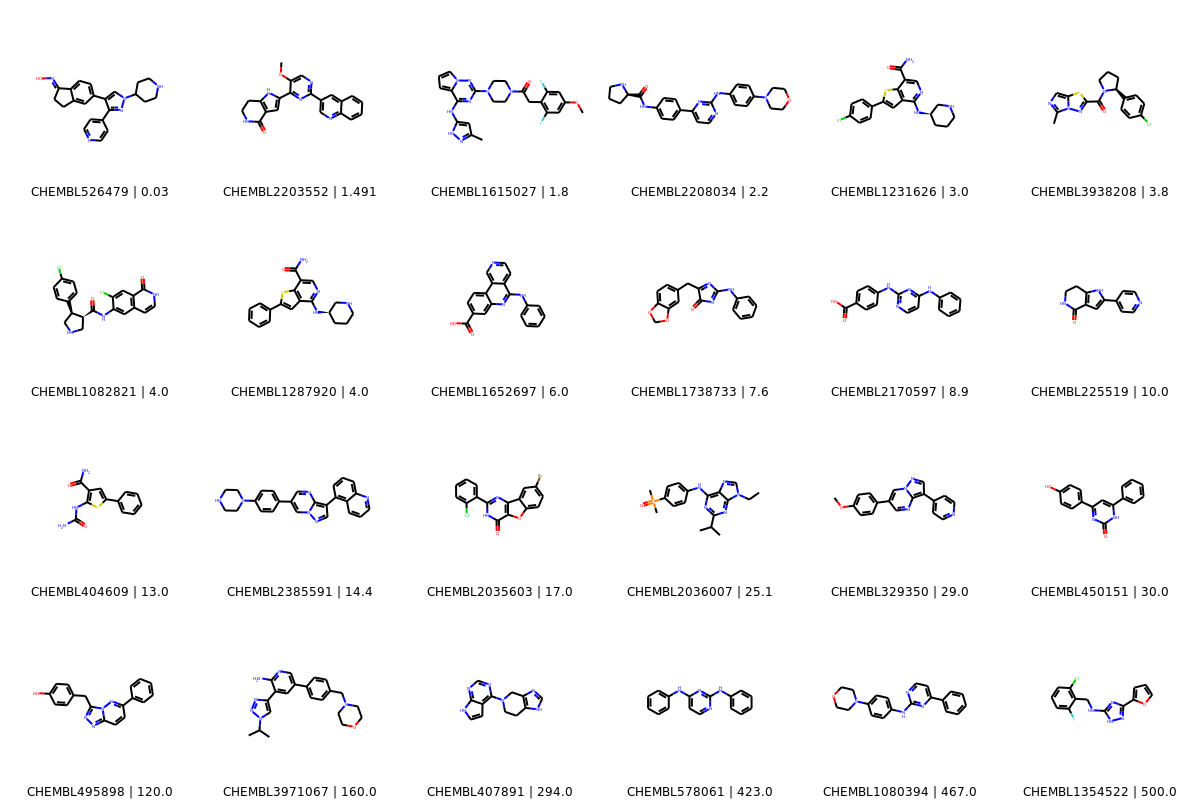

In [59]:
print(f'Molecule ChEMBL ID | minimum activity value')

image = Draw.MolsToGridImage(
    mols=molecules_with_kinase_targets.smiles.apply(lambda x: Chem.MolFromSmiles(x)).tolist(),
    legends=molecules_with_kinase_targets.apply(lambda x: f'{x.molecule_chembl_id} | {min(x.standard_value)}', axis=1).to_list(),
    molsPerRow=6,
    maxMols=100
)
image

In [60]:
image.save('figures/ligand_analysis_active_kinase_targets.pdf')

Show activity distribution for molecules with kinase target(s) - plot only minimum activity per molecule (in case there are multiple kinase activities measured).

Text(0.5, 0, 'Minimum activity value per molecule with kinase target(s)')

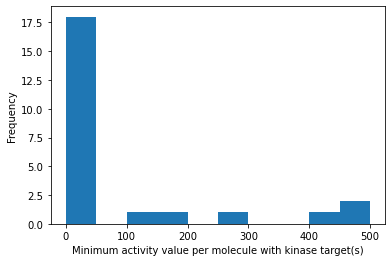

In [61]:
ax = molecules_with_kinase_targets.standard_value.apply(min).plot(kind='hist')
ax.set_xlabel('Minimum activity value per molecule with kinase target(s)')

#### Molecules with kinase target(s) with activity of <= 5 nM

In [62]:
activities_active_kinases_5nm = activities_active_kinases[
    activities_active_kinases.standard_value <= 5
]

In [63]:
print(f'Number of molecules with kinase target(s) and an activity of <= 5 nM: {activities_active_kinases_5nm.groupby("molecule_chembl_id").first().shape[0]}')

Number of molecules with kinase target(s) and an activity of <= 5 nM: 8


In [64]:
filtering = add_filtering_step(filtering, activities_active_kinases_5nm, 'Only molecule-kinase pairs with activity <= 5 nM')
filtering

,filtering_step,molecules,targets,assays,activities
0,ChEMBL bioactivity entries,39,100,155,165
1,Remove non-nM activities,39,100,155,165
2,Only human entries,38,92,139,149
3,Get minimum IC50 per molecule-target pair,38,92,110,113
4,"Only ""active"" molecule-target pairs",25,57,65,66
5,Only molecule-kinase pairs,24,49,57,58
6,Only molecule-kinase pairs with activity <= 5 nM,8,6,7,8
